In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import seaborn as sns
import system_comparison_plots
%matplotlib inline


In [8]:
spd_pipeline_one = system_comparison_plots.load_spd_pipeline_one()

In [39]:
len(spd_pipeline_one)

67

In [16]:
ifl_pipeline_one = system_comparison_plots.load_inferline_pipeline_one()

In [40]:
len(ifl_pipeline_one)

33

In [17]:
pipeline_one_df = pd.concat([spd_pipeline_one, ifl_pipeline_one])

# Plot the results

14    119
15    203
12    242
17    356
16    418
13    483
Name: lambda, dtype: int64 3          NaN
8          NaN
12         NaN
13    1.311483
14         NaN
15         NaN
16         NaN
17         NaN
24         NaN
28         NaN
31         NaN
Name: cost, dtype: float64
8     119
9     203
6     242
11    356
10    418
7     483
Name: lambda, dtype: int64 3          NaN
6          NaN
7          NaN
8     0.650412
9          NaN
10         NaN
11         NaN
13         NaN
24         NaN
28         NaN
31         NaN
Name: cost, dtype: float64
40    191
38    212
37    382
39    426
36    575
41    766
Name: lambda, dtype: int64 0    NaN
5    NaN
10   NaN
18   NaN
19   NaN
30   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: cost, dtype: float64
34    191
32    212
31    382
33    426
30    575
35    766
Name: lambda, dtype: int64 0          NaN
5          NaN
10         NaN
18         NaN
19         NaN
30    3.809592
31         NaN
32         NaN
33         Na

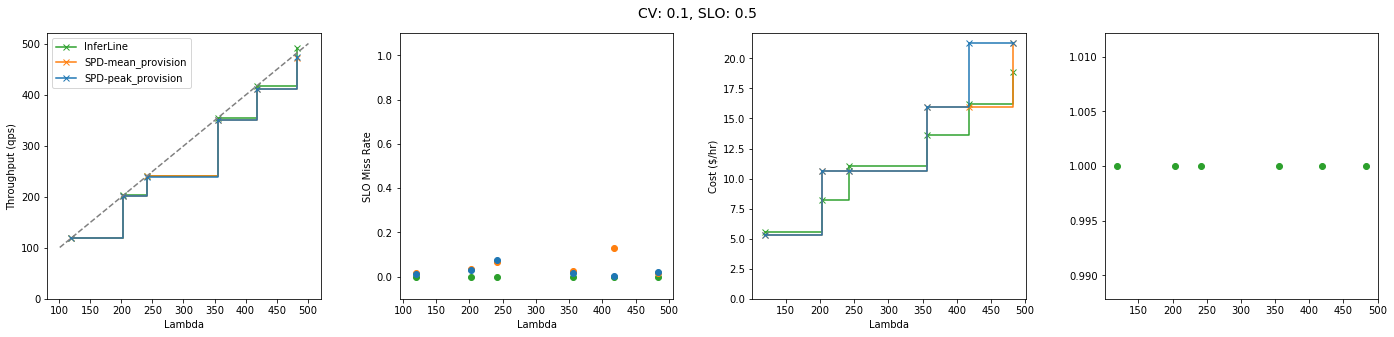

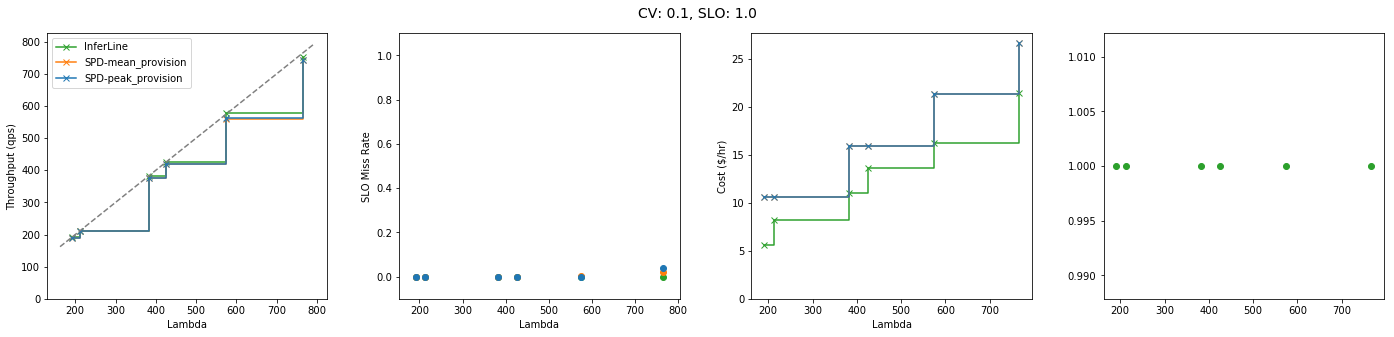

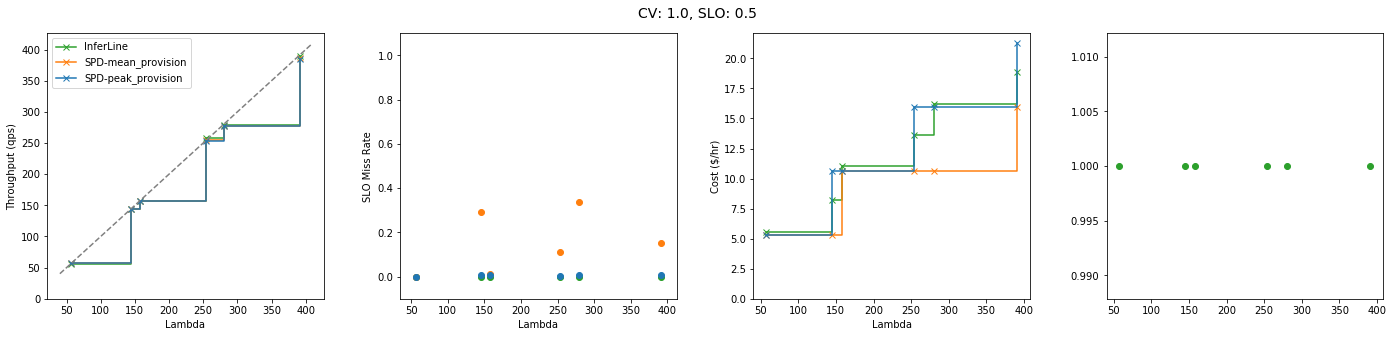

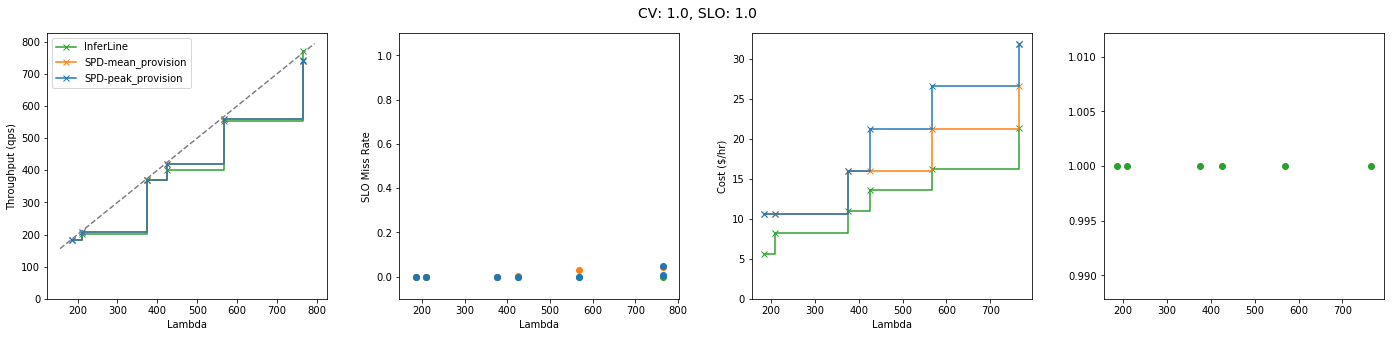

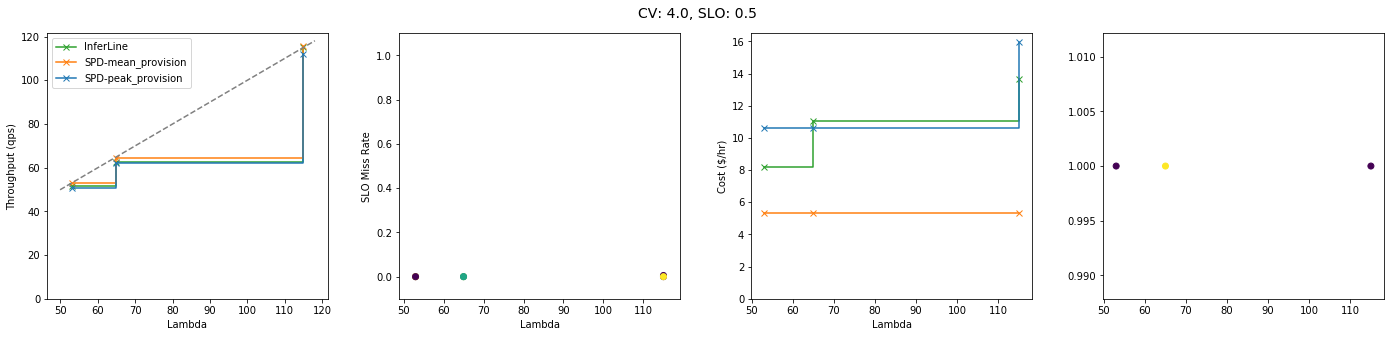

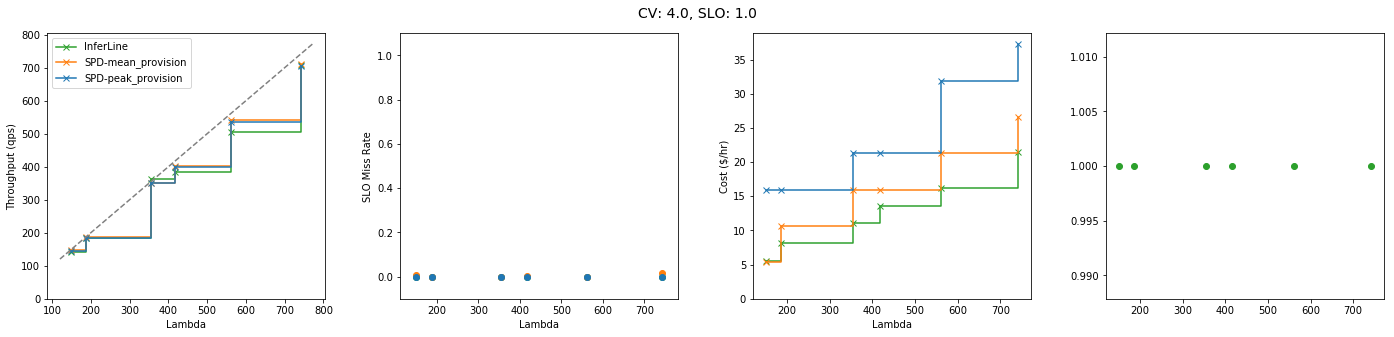

In [41]:
names = pipeline_one_df.name.unique()
colors = sns.color_palette(n_colors=len(names))
cmap = dict(zip(names, colors))

for cv, cv_group in pipeline_one_df.groupby(pipeline_one_df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        fig, (ax_thru, ax_slo, ax_cost, ax_cost_factor) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
#         fig, (ax_lam, ax_slo) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        ng = slo_group.groupby(slo_group.name)
        ifl_costs = ng.get_group("InferLine").sort_values("lambda")
        for name, name_group in ng:
            name_group = name_group.sort_values("lambda")
            ax_cost.step(name_group["lambda"], name_group.cost, "x-", where="post", c=cmap[name], label=name)
            ax_thru.step(name_group["lambda"], name_group.throughput, "x-", where="post", c=cmap[name], label=name)
            ax_slo.scatter(name_group["lambda"], name_group.slo_miss_rate, c=cmap[name], label=name)
            try:
                ax_cost_factor.scatter(name_group["lambda"], ng.get_group(name).sort_values("lambda").cost / ng.get_group("InferLine").sort_values("lambda").cost, c=cmap[name], label=name)
            except ValueError:
                print(name_group["lambda"], name_group.cost / ng.get_group("InferLine").cost)
                

#             ax_slo_25.scatter(name_group.lambda, name_group.slo_plus_25_per_miss_rate, c=cmap[name], label=name)
        ax_thru.plot(ax_thru.get_xlim(), ax_thru.get_xlim(), "--", c="grey")
        ax_thru.set_ylim(bottom=0)
        ax_cost.set_ylabel("Cost ($/hr)")
        ax_cost.set_xlabel("Lambda")
        ax_cost.set_ylim(bottom=0)
        ax_slo.set_xlabel("Lambda")
        ax_slo.set_ylabel("SLO Miss Rate")
        ax_slo.set_ylim(bottom=-0.1, top=1.1)
#         ax_slo.set_ylim((-.1,1.2))
        ax_thru.set_xlabel("Lambda")
        ax_thru.set_ylabel("Throughput (qps)")
#         ax_slo.legend(loc=0)

        ax_thru.legend(loc=0)
        fig.suptitle("CV: {cv}, SLO: {slo}".format(cv=cv, slo=slo), fontsize=14)
        plt.tight_layout(pad=3)

            
    

In [31]:
ng.get_group("InferLine").cost

3     18.8930
8      8.1825
13    16.2320
24     5.5880
28    11.0430
31    13.6375
Name: cost, dtype: float64

In [35]:
ng.get_group("SPD-mean_provision").cost

12    10.644
13    21.288
14     5.322
15    10.644
16    15.966
17    15.966
Name: cost, dtype: float64

In [ ]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        for name, name_group in slo_group.groupby(slo_group.name):
            ax2.scatter(bytes_per_machine(name_group["cost"], name_group["lambda"]*MB_per_query), name_group["slo_miss_rate"], color="red")
ax2.set_ylabel("SLO Miss Rate")
ax2.set_xlabel("Per-node traffic (MBps)")
fig.suptitle("Effect of contention on SLO miss rate")



Inferline/TensorFlow Serving
Machine A: client -----> machine B: [Clipper ---> model 1, model 2, etc.] 


SPD (old):

Machine B: [SPD replica 1, SPD replica 2]

SPD (new):

machine A: client ---> Machine B: [SPD replica 1, SPD replica 2]


-----------------------------------

Dealing with contention:
1) Same utilization factor for all three systems, tuned for Inferline (utilization == 0.7)
2) Utilization factor but tuned for each system independently
3) Profile inferline models under contention and don't apply utilization factor
